
**7th International Conference on Debris-Flow Hazards Mitigation**   
## Deciphering debris-flow seismograms at Illgraben, Switzerland    
**Michaela Wenner, Fabian Walter, Brian McArdell, Daniel Farinotti**

ETH Zurich



### Abstract

Mass wasting, such as rockfalls, landslides and debris flows in steep mountain terrain, has a high destructive potential, and plays a key role in both erosion and landscape evolution. As an alternative to many conventional approaches, seismology allows monitoring of such mass movements at safe distances, provides estimates of event location and timing, and can give insights into dynamics and rheology granular flows. Here, we analyze seismic data recorded during the 2017 and 2018 debris-flow seasons at Illgraben, a steep canyon located in Switzerland. Yearly precipitation is controlled by summer rainstorms with high rainfall intensity during which mass wasting including rock-slope failure and debris flows occur regularly. The frequent debris-flow occurrence (on average three events per year) makes the Illgraben an ideal site for cross-validating a seismically-derived event catalog of mass movements with “ground-truth data”, such as digital terrain models, flow depths estimates and other in-torrent measurements. We present seismic frequency characteristics of the Illgraben debris-flow series and investigate how the seismic signature depends on actual debris-flow characteristics, such as grain sizes, and on propagation effects of the generated seismic waves. Whereas these two effects are usually difficult to separate, the source component contains valuable information on the flow’s material composition. Stations that are close to the torrent, we find that dominant frequencies in the recorded signal reflect the distance to the dominant source. For one particular station, this is shown on recordings of several events, where a dominant frequency of about 5.5 Hz indicates the passing of the flow at a 48m check dam. Power spectral densities at that instance give an estimate of the particle content of the debris flow. We also find that a jump in dominant frequency does not necessarily reflect the location of the flow front. Seismic studies of debris-flow dynamics and material composition should therefore not be limited to entire debris-flow seismograms, but instead focus on individual time windows and consider different sensors separately. The presented analysis underlines the use of seismic data in torrent and landscape studies.

![bla](material/Illgraben_all-01.png)

Fig. 1. (a) Overview of the Illgraben catchment and the instrumentation installed during the debris-flow season (June-August) 2018. Seismometer locations (white triangles), the area of sediment supply for the debris flows (shaded red area), and the position of the 48 m tall check dam 1, and check dam 29 (black squares) are depicted (b) 3D orthophoto with sediment deposition area in red and check dam 1 shown on a photo. (c) Channel-receiver distances for all seismic stations installed in 2018. The y-axis represents the distance whereas the x-axis marks the position along the channel (origin at the head of the catchment; 5000m corresponds to the Illbach inflow into the Rhône river). Dashed (continuous) lines show the section where the flow is approaching (moving away from) the station.

In [1]:
%matplotlib notebook
import obspy
from obspy import UTCDateTime
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
from matplotlib import dates
from matplotlib.dates import DateFormatter
import matplotlib
import seaborn as sns
import pandas as pd
import matplotlib.collections as mcoll
import matplotlib.path as mpath
from scipy.signal import savgol_filter
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm 
from collections import Counter
import matplotlib.gridspec as GridSpec
import matplotlib.gridspec as gridspec
from scipy.signal import argrelextrema
from scipy.fftpack import hilbert
from scipy.signal import (cheb2ord, cheby2, convolve, get_window, iirfilter,
                          remez)
from scipy.signal import sosfilt
from scipy.signal import zpk2sos
import scipy
from scipy import signal
from scipy.optimize import curve_fit
from datetime import date
import datetime

In [2]:
def colorline(
    x, y, z=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0),
        linewidth=3, alpha=1.0):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha)

    ax = plt.gca()
    ax.add_collection(lc)

    return lc


def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments


def rere(st, inv):
    #preprocessing
    pre_filt = [0.005, 0.006, 45.0, 50.0]
    st.detrend('linear')
    st.detrend('demean')
    #st.trim(ev_time, end_time)
    st.remove_response(inventory = inv, pre_filt = pre_filt, \
            output = 'VEL', water_level = 60, plot=False)
    #st.filter('bandpass', freqmin = freq_min, freqmax = freq_max)
    return st

def peak_filt(data, start, end, freq):
    dat = data[start:end]
    fe = 0.5 * st2[3].stats.sampling_rate
    f = freq / fe 
    z, p, k = iirfilter(4, f, btype='lowpass', ftype='butter', output='zpk')
    sos = scipy.signal.zpk2sos(z,p,k)
    data_filt_cut = sosfilt(sos, dat)
    data[start:end] = data_filt_cut
    return data

def plot_trace_spec(spl1,fmin=1,fmax=30): 
    '''
    Plot trace and spectrogram in one plot
    '''
    #from obspy.imaging.spectrogram import spectrogram
    import matplotlib.pyplot as plt
    import numpy as np
    print(spl1)
    #info
    beg = spl1.stats.starttime
    end = spl1.stats.endtime
    #setup figure
    fig = plt.figure()
    #example code
    ax1 = fig.add_axes([0.1, 0.75, 0.7, 0.2]) #[left bottom width height] 
    ax2 = fig.add_axes([0.1, 0.1, 0.7, 0.60], sharex=ax1)
    ax3 = fig.add_axes([0.83, 0.1, 0.03, 0.6])
    #make time vector
    t = np.arange(spl1.stats.npts) / spl1.stats.sampling_rate
    #plot waveform (top subfigure)
    ax1.plot(t, spl1.data, 'k')
    #plot spectrogram (bottom subfigure)
    spl2 = spl1
    fig = spl2.spectrogram(dbscale=True, show=False, axes=ax2, cmap=plt.get_cmap('jet'))
    #ax = fig.axes[1]mappable = ax2.images[0]
    plt.colorbar(mappable=mappable, cax=ax3)
    ax2.set_ylim(0, 50)
    plt.show()
    #print some info
    print('Figure starttime = %s'%beg) 
    print('Figure endtime = %s'%end)

### Debris flow seismograms

In [3]:
plt.style.use('seaborn-white')
infos = pd.read_csv('/Users/michiwen/Illgraben/general_info/debris_flows/debris_flows.csv')

dates_flows = { 1:'2011-07-13', 2:'2011-07-19', 3:'2017-05-19', 4:'2017-05-29', 5:'2017-06-03', 6:'2017-06-14',7:'2018-06-11', \
               8:'2018-06-12', 9:'2018-07-25', 10:'2018-08-08'}

infos.head()

,date,timeCD1,timeILL11,timeILL12,timeILL13,timeILL16,timeILL17,timeILL18,velocity,depth,volume,precipitation,infos
0,#2011-05-21,16:47:00,,,,1.2,small event - time CD10,NaN,NaN,NaN,NaN,NaN,NaN
1,#2011-06-29,20:14:00,,,,22.8,roll waves,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-07-13,15:00:00,15:06:00,,,,,31.2,quite small,NaN,NaN,NaN,NaN
3,2011-07-19,17:38:00,17:43:00,,,,,18.8,-,NaN,NaN,NaN,NaN
4,#2011-10-07,02:29:00,,,,9.4,-,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#choose event
ev_date = dates_flows[10]

#read event infos from file
event = infos.loc[infos['date'] == ev_date]

#read  event times from file, t_ref being station of interest
t_CD01 = UTCDateTime('%sT%s' %(event.iloc[0]['date'], event.iloc[0]['timeCD1']))
#t_ref = UTCDateTime('%sT%s' %(event.iloc[0]['date'], event.iloc[0]['timeILL13']))

In [5]:
#read data
if t_CD01.year == 2017:
    st = obspy.read('/Users/michiwen/Desktop/raw_data17/ILL*/*HZ.D/*%3d*' %t_CD01.julday)
    inv = obspy.read_inventory('/Users/michiwen/Illgraben/general_info/RESP_ILL/ILL1-8_inventory.xml')
elif t_CD01.year == 2018:
    st = obspy.read('/Users/michiwen/Desktop/raw_data18/ILL*/*HZ.D/*%3d*' %t_CD01.julday)
    inv = obspy.read_inventory('/Users/michiwen/Illgraben/general_info/RESP_ILL/ILL11-18_inventory.xml')
elif t_CD01.year == 2011:     
    st = obspy.read('/Users/michiwen/Desktop/ILL_Arnaud/R%3d.02/IGB02*BHZ*' %t_CD01.julday)
st.trim(t_CD01 - 0.5*7200, t_CD01 + 0.5*7200)
st.merge(method=1, fill_value='interpolate')
#st.decimate(2)
st = rere(st, inv)
st.filter('bandpass', freqmin=1, freqmax=45)

8 Trace(s) in Stream:
XP.ILL18..EHZ | 2018-08-08T16:45:08.000001Z - 2018-08-08T18:45:08.000001Z | 100.0 Hz, 720001 samples
XP.ILL11..HHZ | 2018-08-08T16:45:08.000000Z - 2018-08-08T18:45:08.000000Z | 100.0 Hz, 720001 samples
XP.ILL17..EHZ | 2018-08-08T16:45:08.000000Z - 2018-08-08T18:45:08.000000Z | 100.0 Hz, 720001 samples
XP.ILL14..EHZ | 2018-08-08T16:45:08.000000Z - 2018-08-08T18:45:08.000000Z | 100.0 Hz, 720001 samples
XP.ILL13..EHZ | 2018-08-08T16:45:08.000000Z - 2018-08-08T18:45:08.000000Z | 100.0 Hz, 720001 samples
XP.ILL16..EHZ | 2018-08-08T16:45:08.000000Z - 2018-08-08T18:45:08.000000Z | 100.0 Hz, 720001 samples
XP.ILL12..EHZ | 2018-08-08T16:45:08.000000Z - 2018-08-08T18:45:08.000000Z | 100.0 Hz, 720001 samples
XP.ILL15..EHZ | 2018-08-08T16:45:08.000000Z - 2018-08-08T18:45:08.000000Z | 100.0 Hz, 720001 samples

In [6]:
from obspy import signal
from obspy.signal import filter
#Cut data according to time when flow is passing the station
env = obspy.signal.filter.envelope(st[0].data)
#env_sm = obspy.signal.util.smooth(env, 6000)
#for stations 14, 15, 16, 17
#t_CD01 = UTCDateTime('%sT%s' %(event.iloc[0]['date'], event.iloc[0]['timeILL18']))
#t_ref = t_CD01 +200
dt_m = 400
dt_p = 400
times = st[0].times()
t_ref = st[0].stats.starttime + times[np.argmax(env)]

#dt = np.abs(t_ref - t_CD01)
#td = dt

tr = st[0].copy()
#tr.normalize()
fs = tr.stats.sampling_rate
tr1 = tr.copy()
tr1.trim(t_ref - dt_m, t_ref + dt_p)

XP.ILL18..EHZ | 2018-08-08T17:40:44.860001Z - 2018-08-08T17:54:04.860001Z | 100.0 Hz, 80001 samples

In [7]:
st_ev = obspy.read('/Users/michiwen/Desktop/raw_data18/ILL*/*HZ.D/*%s' %UTCDateTime(ev_date).julday)
inv = obspy.read_inventory('/Users/michiwen/Illgraben/general_info/RESP_ILL/ILL11-18_inventory.xml')
st_ev.trim(t_ref - 15*60, t_ref + 45*60)
st_ev = rere(st_ev,inv)
st_ev.detrend('demean')
st_ev.filter('bandpass', freqmin=3, freqmax = 45)

8 Trace(s) in Stream:
XP.ILL11..HHZ | 2018-08-08T17:32:24.860000Z - 2018-08-08T18:32:24.860000Z | 100.0 Hz, 360001 samples
XP.ILL12..EHZ | 2018-08-08T17:32:24.860000Z - 2018-08-08T18:32:24.860000Z | 100.0 Hz, 360001 samples
XP.ILL13..EHZ | 2018-08-08T17:32:24.860000Z - 2018-08-08T18:32:24.860000Z | 100.0 Hz, 360001 samples
XP.ILL14..EHZ | 2018-08-08T17:32:24.860000Z - 2018-08-08T18:32:24.860000Z | 100.0 Hz, 360001 samples
XP.ILL15..EHZ | 2018-08-08T17:32:24.860000Z - 2018-08-08T18:32:24.860000Z | 100.0 Hz, 360001 samples
XP.ILL16..EHZ | 2018-08-08T17:32:24.860000Z - 2018-08-08T18:32:24.860000Z | 100.0 Hz, 360001 samples
XP.ILL17..EHZ | 2018-08-08T17:32:24.860000Z - 2018-08-08T18:32:24.860000Z | 100.0 Hz, 360001 samples
XP.ILL18..EHZ | 2018-08-08T17:32:24.860001Z - 2018-08-08T18:32:24.860001Z | 100.0 Hz, 360001 samples

/Users/michiwen/anaconda3/envs/obspy/lib/python3.5/site-packages/obspy/core/trace.py:2176: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(self.data.dtype, float):


<IPython.core.display.Javascript object>


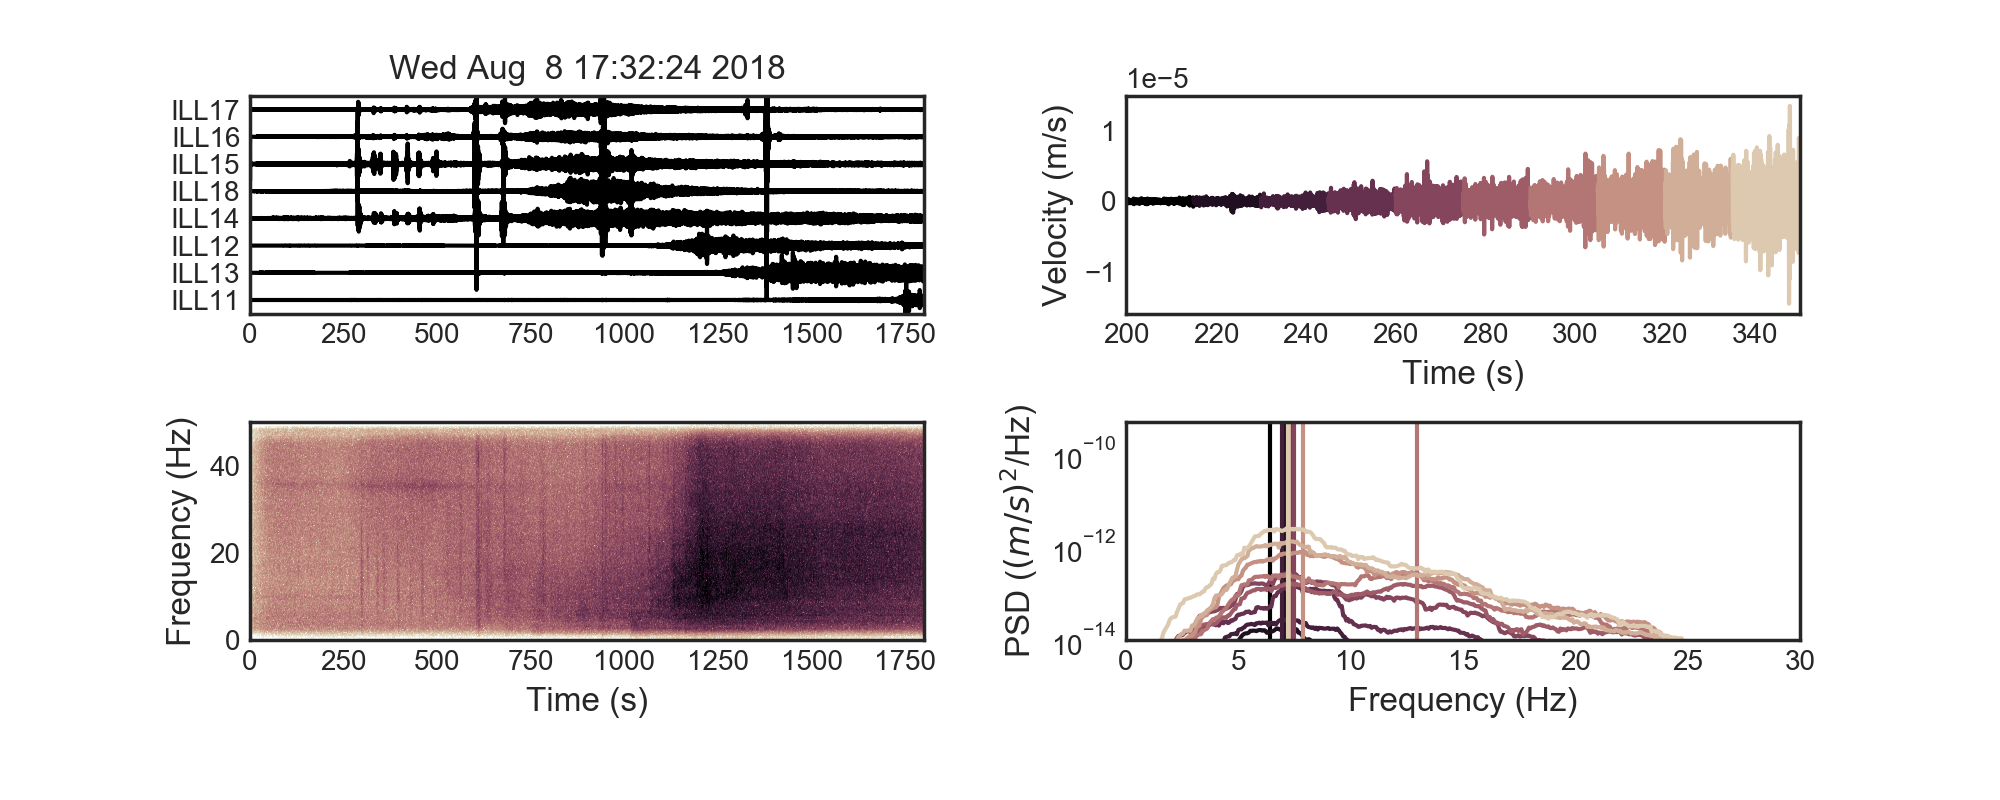

In [9]:
st1 = st_ev.copy()
st1.trim(t_ref - 15*60, t_ref + 45*60)
st1.normalize()

fig = plt.figure(figsize=(10,4))
#colors = ['darkgray', 'indianred', 'goldenrod', 'olivedrab', 'steelblue', 'skyblue', 'darkslategrey', 'maroon']
ax1 = plt.subplot(221)
i = 0
#for idx,tr in enumerate(st1):
#    if tr.stats.station == 'ILL14' or tr.stats.station == 'ILL15' or tr.stats.station == 'ILL16':
#        tr.data = tr.data*4
#    ax1.plot(tr.times(),tr.data-i, color='k')
#    i += 2
ax1.plot(st1[6].times(), st1[6].data*1, color='k')
ax1.plot(st1[5].times(), st1[5].data*12 - 2, color='k')
ax1.plot(st1[4].times(), st1[4].data*8 - 4, color='k')
ax1.plot(st1[7].times(), st1[7].data*1 - 6, color='k')
ax1.plot(st1[3].times(), st1[3].data*6 - 8, color='k')
ax1.plot(st1[1].times(), st1[1].data*1.5 - 10, color='k')
ax1.plot(st1[2].times(), st1[2].data*1.5 - 12, color='k')
ax1.plot(st1[0].times(), st1[0].data*1.5 - 14, color='k')

#ax1.tick_params(axis='both', labelsize='large')
ax1.set_xlim(0, 1800)
ax1.set_ylim(-15, 1)
ax1.set_title(st1[0].stats.starttime.ctime())
labels = ['ILL17', 'ILL16', 'ILL15', 'ILL18', 'ILL14', 'ILL12', 'ILL13', 'ILL11']
plt.yticks(np.linspace(0,-14,8), labels)
#cmap = plt.get_cmap('RdGy')
#cmap = sns.cubehelix_palette(10, light=2, dark=0, start=0, rot=-0.4, as_cmap=True)
cmap = sns.cubehelix_palette(as_cmap=True, start=0.3, light=1.8, dark=-0.05)
ax2=plt.subplot(223)
ax2.specgram(st1[1].data, Fs=100, NFFT=512, pad_to=2048, noverlap=400, scale='dB', cmap=cmap)

ax2.set_xlabel('Time (s)', fontsize=12)
ax2.set_ylabel('Frequency (Hz)', fontsize=12)
#ax2.tick_params(axis='both', labelsize='large')
ax2.set_xlim(0, 1800)
#plt.savefig('/Users/michiwen/Desktop/plots/specgram_08082018')
#plt.savefig('/Users/michiwen/Desktop/plots/event_08082018')
#plt.sca(ax1)

#plt.tight_layout()
#plt.savefig('/Users/michiwen/Desktop/plots/event_08082018.png', format="PNG")
#plt.savefig('/Users/michiwen/Desktop/plots/event_08082018.ps', format="PS")

'''
Plot Zoom in increasing peak frequencies
'''
t0 = 200
t1 = 350
tr2 = tr1.copy()
tr2.filter('bandpass', freqmin=3, freqmax=25)
t_start = tr2.stats.starttime
tr2.trim(t_start + float(t0), t_start + float(t1))
win = int(len(tr2.data)/10)
colors = sns.cubehelix_palette(10, start=0.3,light=0.8, dark=0, reverse=True)

ax3 = plt.subplot(224)
#PLOT SPECTRAS WITH COLORCODE
i = 0 
j = 0
while i < len(tr2.data)-win:
    dat = tr2.data[i:i+win]
    f, Pxx = scipy.signal.periodogram(dat, fs)
    pxx_sm = obspy.signal.util.smooth(Pxx, 20)
    ax3.semilogy(f, pxx_sm, color = colors[j])
    ax3.axvline(f[np.argmax(pxx_sm)], color = colors[j])
    i += win
    j += 1
ax3.set_xlim(0, 30)
ax3.set_ylim(1e-14, 5e-10)
ax3.set_xlabel('Frequency (Hz)', fontsize=(12))
ax3.set_ylabel('PSD ($(m/s)^2$/Hz)', fontsize = 12)
#ax3.tick_params(axis='both', labelsize='large')

#PLOT WAVEFORM WITH COLORCODE
ax4 = plt.subplot(222)
x = np.linspace(int(t0), int(t1), len(tr2.data))
i = 0 
j = 0
while i < len(tr2.data)-win:
    dat = tr2.data[i:i+win]
    xdat = x[i:i+win]
    ax4.plot(xdat, dat, color = colors[j])
    i += win
    j += 1
ax4.set_xlim(int(t0), int(t1))
ax4.set_xlabel('Time (s)', fontsize=12)
ax4.set_ylabel('Velocity (m/s)', fontsize=12)
#ax4.tick_params(axis='both', labelsize='large')
from matplotlib import ticker
fig.subplots_adjust(hspace=0.5, wspace=0.3, bottom=0.2)
#scale_pow = 2
#def my_formatter_fun(x, p):
#    return "%.2f" % (x * (10 ** scale_pow))
#ax2.get_yaxis().set_major_formatter(ticker.FuncFormatter(my_formatter_fun))
#ax2.set_ylabel('Velocity (m/s) ' + '$10^{{{0:d}}}$'.format(scale_pow))
ax4.ticklabel_format( axis='y', style='sci', scilimits=(2,2))
#plt.tight_layout()
plt.savefig('/Users/michiwen/Desktop/plots/ILL12_evspec_%s.png' %tr1.stats.starttime.date, format='PNG')
plt.savefig('/Users/michiwen/Desktop/plots/ILL12_evspec_%s.ps' %tr1.stats.starttime.date, format='PS')

plt.show()

### All events

In [10]:
station17 = 'ILL02'
station18 = 'ILL12'
st_all = obspy.core.stream.Stream() 
for i in list(dates_flows.values())[3:]:
    ev_date = UTCDateTime(i)
    print(ev_date)
    event = infos.loc[infos['date'] == i]
    #read event times from file, t_ref being station of interest
    t_CD01 = UTCDateTime('%sT%s' %(event.iloc[0]['date'], event.iloc[0]['timeCD1'])) # read data
    if ev_date.year == 2017:
        st = obspy.read('/Users/michiwen/Desktop/raw_data17/%s/*HZ.D/*%3d*' %(station17, t_CD01.julday))
        inv = obspy.read_inventory('/Users/michiwen/Illgraben/general_info/RESP_ILL/ILL1-8_inventory.xml') 
    elif ev_date.year == 2018:
        st = obspy.read('/Users/michiwen/Desktop/raw_data18/%s/*HZ.D/*%3d*' %(station18, t_CD01.julday))
        inv = obspy.read_inventory('/Users/michiwen/Illgraben/general_info/RESP_ILL/ILL11-18_inventory.xml')
    elif ev_date.year == 2011:
        #st = obspy.read('/Users/michiwen/Desktop/ILL_Arnaud/R%3d.02/IGB02*BHZ*' %ev_date)
        continue
    st.trim(t_CD01 - 7200, t_CD01 + 7200)
    st.merge(method=1, fill_value='interpolate')

    st = rere(st, inv)
    st.filter('bandpass', freqmin=1, freqmax=30)
    st_all.append(st[0])

2017-05-29T00:00:00.000000Z
2017-06-03T00:00:00.000000Z
2017-06-14T00:00:00.000000Z
2018-06-11T00:00:00.000000Z
2018-06-12T00:00:00.000000Z
2018-07-25T00:00:00.000000Z
2018-08-08T00:00:00.000000Z


In [ ]:

import datetime
st1 = st_all.copy()
fs = 100
st2 = obspy.core.stream.Stream()
st2.append(st1[0])
st2.append(st1[1])
st2.append(st1[2]) 
st2.append(st1[3])
st2.append(st1[4]) 
st2.append(st1[5])
st2.append(st1[6])
#st2.append(st_n[0])


#st2[4].data = peak_filt(st2[4].data.copy(), 52453, 55330, 10)
'''
Calculate dominant frequencies
'''
smoothing = 0

st_low = st2.copy()
st_low.filter('bandpass', freqmin=1, freqmax=10) 
st_mid = st2.copy()
st_mid.filter('bandpass', freqmin=5, freqmax=15) 
st_high = st2.copy()
st_high.filter('bandpass', freqmin=15, freqmax=30)
#st_all = st2.copy()
#st_all.filter('bandpass', freqmin=, freqmax=8)

def vgl_domfreq(st2, sm):
    '''
    compare dominant frequencies of each event
    '''
    def func(x, m, b):
        return m*x + b
    colors = ['olivedrab', 'darkslategrey', 'indianred', 'steelblue', 'maroon', 'goldenrod', 'darkgray']
    #colors = ["#5c8b3f",  "#1636e8",  "#aeb325", "#929a97","#9e55a2", "#874140", "#353b4b"]
    #colors = sns.color_palette('dark', 5)
    #colors = ["#1b9e77", "#d95f02", "#7570b3", "#e7298a", "#66a61e", "#e6ab02", "#a6761d"]
    fig = plt.figure(figsize=(10,4))
    gs = gridspec.GridSpec(1, 2,width_ratios=[15, 6])

    ax1 = plt.subplot(gs[0])
    ax3 = plt.subplot(gs[1])
    ax2 = ax1.twinx()
    for idx, tr in enumerate(st2):
        #f, ax = plt.subplots(figsize=(8,5))
        trtime = tr.stats.starttime
        
        #Read geophone data
        cd_data = pd.read_csv('/Users/michiwen/Illgraben/data/debris_flows/%02d%02d%02d_Staumauer_Ereignisdaten.dat' \
                              %(trtime.year-2000, trtime.month, trtime.day), \
                              names = ["bla1", "bla2", "bla3", "date", "counts"])
        cddate = pd.to_datetime(cd_data["date"]) - datetime.timedelta(hours=1)
        cdcounts = cd_data["counts"]
        cd_utc = []
        for i in cddate:
            cd_utc.append(UTCDateTime(pd.to_datetime(i)))

        cd_secs = []
        for i in cd_utc:
            cd_secs.append(UTCDateTime(i) - tr.stats.starttime)
        
        #Read precipitation data

        if trtime.year == 2017:
            precip17 = pd.read_csv('/Users/michiwen/Illgraben/precipitation/Illgraben_Pluvio_Ill1-3_2017.csv')
            df = precip17.loc[(precip17["CODE"] == 'ILL2') & (pd.to_datetime(precip17["DATUM"]).dt.date == trtime.date)]
            df1 = df[["DATUM","PSUM"]]
            p_diff = np.diff(df1["PSUM"].values)
            tt =  df1["DATUM"].values
            tt_dt = []
            for i in range(1,len(tt)):
                tt_dt.append((datetime.datetime.strptime(tt[i], '%Y-%m-%d %H:%M:%S')) - datetime.timedelta(hours=1))
        elif trtime.year == 2018:
            precip18 = pd.read_csv('/Users/michiwen/Illgraben/precipitation/data_2018.csv')
            df = precip18.loc[(precip18["stao_nr"] == 2) & (pd.to_datetime(precip18["timestamp [utc+1]"]).dt.date == trtime.date)]
            df1 = df[["timestamp [utc+1]","psum [mm m-2]"]]
            p_diff = np.diff(df1["psum [mm m-2]"].values)
            tt =  df1["timestamp [utc+1]"].values
            tt_dt = []
            for i in range(1,len(tt)):
                tt_dt.append((datetime.datetime.strptime(tt[i], '%Y-%m-%d %H:%M') - datetime.timedelta(hours=1)))
        cd_secs = np.asarray(cd_secs)
        if tr.stats.starttime.date == datetime.date(2017, 5, 29):
            shift = 0
            #shift = -113
            tr.data = np.roll(tr.data, shift*100)
            tr_norm = tr.copy()
            tr_norm.normalize()
            x_norm = np.linspace(0 ,len(tr_norm.data)/100 , len(tr_norm.data))
            cd_secs = cd_secs + shift
            #ax1.plot(x_norm-7100, 8*tr_norm.data, color=colors[idx])
        elif tr.stats.starttime.date == datetime.date(2017, 6, 3):
            shift = 31
            #shift = 4 - 131
            tr.data = np.roll(tr.data, shift*100)
            cd_secs = cd_secs + shift
        elif tr.stats.starttime.date == datetime.date(2017, 6, 14):
            shift = 31
            #shift = 16 -197
            tr.data = np.roll(tr.data, shift*100)
            cd_secs = cd_secs + shift
        elif tr.stats.starttime.date == datetime.date(2018, 6, 11):
            shift = -68
            tr.data = np.roll(tr.data, shift*100)
            cd_secs = cd_secs + shift
        elif tr.stats.starttime.date == datetime.date(2018, 6, 12):
            shift = -159
            tr.data = np.roll(tr.data, shift*100)
            cd_secs = cd_secs + shift
        elif tr.stats.starttime.date == datetime.date(2018, 7, 25):
            #shift = -383
            shift = -342
            tr.data = np.roll(tr.data, shift*100)
            cd_secs = cd_secs + shift
        elif tr.stats.starttime.date == datetime.date(2018, 8, 8):
            shift = -226 
            tr.data = np.roll(tr.data, shift*100)
            cd_secs = cd_secs + shift
            tr_norm = tr.copy()
            tr_norm.normalize()
            x_norm = np.linspace(0 ,len(tr_norm.data)/100 , len(tr_norm.data))
            ax1.plot(x_norm-7100, 8*tr_norm.data, color=colors[idx], alpha=0.7, linewidth=0.3)

        f_spec, t, Sxx = signal.spectrogram(tr.data, fs, nperseg=512, noverlap = 256)
        print(cd_secs[0])
        dom_fs = []
        en_values = []
        t_thres = []
        for i in range(Sxx.shape[1]):
            sxx_sm = obspy.signal.util.smooth(Sxx[:,i], 0) 
            dom_e = np.argmax(sxx_sm)
            if np.max(sxx_sm) > 1e-12:
                en_values.append(np.max(sxx_sm)) 
                dom_fs.append(f_spec[dom_e])
            else:
                en_values.append(0)
                dom_fs.append(100)
        dom_sm = obspy.signal.util.smooth(np.asarray(dom_fs), sm)
        print(np.max(en_values))

        domt_date = []
        for i in range(len(t)):
            domt_date.append(tr.stats.starttime.datetime + datetime.timedelta(seconds=t[i]))
        ax1.plot(np.asarray(t) - 7100, dom_sm, 'o', label=tr.stats.starttime.date, color=colors[idx], \
                 markeredgewidth=0.7, markersize=3, alpha=1)
        #plt.plot(xdata, func(xdata, *popt), '-', color=colors[idx], linewidth = 3, label='Velocity: %5.2f' %vel)

        
        # Plot geophone counts
        if idx == 6:
            ax2.plot(np.asarray(cd_secs) - 7100,cdcounts, linewidth=3, color = colors[idx], label=tr.stats.starttime.date)
        
       
        ##Calulate spectra
        tr1 = tr.copy()
        tr1.filter('bandpass', freqmin=3, freqmax=10)
        dat = tr1[7230*100:7250*100]
        f_bla, Pxx_bla = scipy.signal.periodogram(dat, 100)
        Pxx_sm = obspy.signal.util.smooth(Pxx_bla, 10)
        ax3.plot(f_bla, Pxx_sm, color = colors[idx], label=tr.stats.starttime.date)
        ax3.set_xlim(2, 10)
        ax3.tick_params(axis='both', labelsize='large')
        ax3.set_xlabel('Frequency (Hz)', fontsize = 14)
        ax3.set_ylabel('PSD ($(m/s)^2$/Hz)', fontsize = 14)
        #ax3.legend(ncol=2, fontsize=12)
        ax3.set_ylim(0,4e-12)
        print(f_bla)
        

    ax1.tick_params(axis='both', labelsize='large')
    ax1.set_ylabel('Frequency (Hz)', fontsize = 14)
    ax1.set_xlabel('Time (s)', fontsize = 14)
    ax1.set_xlim(0, 800)
    ax1.set_ylim(-8, 30) 
    ax2.set_ylim(0,10000)
    ax2.set_ylabel('Counts', fontsize = 14)
    ax2.tick_params(axis='both', labelsize='large')
    plt.tight_layout()
    box = ax1.get_position()

    box = ax3.get_position()
    ax3.set_position([box.x0, box.y0 + box.height * 0.4,
                 box.width, box.height * 0.6])

    # Put a legend below current axis
    ax3.legend(loc='upper left', bbox_to_anchor=(-0.4, -0.3),
          fancybox=True, shadow=True, ncol=2, fontsize=12)
    ax1.fill_between(np.linspace(130, 160, 10), -8, 30, color='grey', alpha=0.2)
    ax3.fill_between(np.linspace(2, 10, 10), 0, 4e-12, color='grey', alpha=0.1)
    ax1.axvline(x=130, ymin=-8, ymax=30, color='k', linestyle='--')
    ax1.axvline(x=300, ymin=-8, ymax=30, color='k', linestyle=':')
    #plt.savefig('/Users/michiwen/Desktop/plots/%s_all_PSD.png' %tr.stats.station)
    #plt.savefig('/Users/michiwen/Desktop/plots/%s_all_2.ps' %tr.stats.station, format='ps')
    plt.savefig('/Users/michiwen/Desktop/plots/freq_final.ps', format='ps')
    plt.show()
    return tr_norm
tr_norm = vgl_domfreq(st2, smoothing)